# Requirements

This code requires you to have record your games (game states) in a JSON format.
<br> And then run the 'JSON to DF' notebook to get appropriate DataFrames.

## Import libraries

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
game = {}

## Read and clean data

In [3]:
def get_data(path, game_no):
    agents_df = pd.read_csv(path+'analysis/game'+str(game_no)+'/agents.csv')
    game_df = pd.read_csv(path+'analysis/game'+str(game_no)+'/game.csv')
    board_df = pd.read_csv(path+'analysis/game'+str(game_no)+'/board.csv')
    bomb_blast_strength_df = pd.read_csv('Games/game_'+str(game_no)+'/bomb_blast_strength.csv')
    bomb_moving_direction_df = pd.read_csv('Games/game_'+str(game_no)+'/bomb_moving_direction.csv')
    flame_life_df = pd.read_csv('Games/game_'+str(game_no)+'/flame_life.csv')
    bomb_life_df = pd.read_csv('Games/game_'+str(game_no)+'/bomb_life.csv')
    
    dfs = [agents_df, game_df, board_df] #, bomb_blast_strength_df, bomb_moving_direction_df, flame_life_df, bomb_life_df]
    board_dfs = [board_df]#, bomb_blast_strength_df, bomb_moving_direction_df, flame_life_df, bomb_life_df]
    
    # Removing unnamed columns
    for f in dfs:
        f.drop('Unnamed: 0', axis=1, inplace=True)    

    # Fixing column names back to tuples for board format dataframes
    cols = {}
    for i in range(11):
        for j in range(11):
            if j == 0:
                cols[str(i)] = (i,j)
            else:
                cols[str(i)+'.'+str(j)] = (i,j)
    
    # Also removing the first row for these boards
    for b in board_dfs:
        b.rename(columns=cols, inplace=True)
        b.drop(0, inplace=True)
        b.reset_index(inplace=True)
        
    return agents_df, game_df, board_df #, bomb_blast_strength_df, bomb_moving_direction_df, flame_life_df, bomb_life_df

## Function to Display board

In [4]:
def display_board(df, step):
    for i in range(11):
        var = ''
        for j in range(11):
            val = df.loc[step, [(i,j)]].values[0]
            l = len(str(val))
            if l == 1:
                space = '  '
            else:
                space = ' '
            var = var + ' ' + str(val) + space 
        print(var)

## Function to get start positions of each player

In [5]:
def get_start_pos(player):
    if player == 'p10':
        return 1, 1
    elif player == 'p11':
        return 9, 1
    elif player == 'p12':
        return 9, 9
    elif player == 'p13':
        return 1, 9        

# Death details

In [6]:
def get_dead(game_df, c):
    dead = []
    for dg in eval(game_df.loc[c-1, 'alive']):
        if dg not in eval(game_df.loc[c, 'alive']):
            dead.append(dg)
    return dead

In [7]:
def check_collapsing_wall(dead_board, pre_dead_board, dead_player):
    if (dead_board.values[0] == 1):# & (pre_dead_board==dead_player):
        return True
    else:
        return False

In [8]:
def check_bombed_flames(dead_board, pre_dead_board, dead_player):
    if (dead_board.values[0] == 4):# & (pre_dead_board==dead_player):
        return True
    else:
        return False

In [9]:
def death_how(dead_tick, dead_player):
    
    player_x = agents_df.loc[dead_tick, 'p'+str(dead_player)+'_position_x']
    player_y = agents_df.loc[dead_tick, 'p'+str(dead_player)+'_position_y']

    pre_dead_board = board_df.loc[dead_tick-1, [(player_x, player_y)]]
    dead_board = board_df.loc[dead_tick, [(player_x, player_y)]]

    if check_collapsing_wall(dead_board, pre_dead_board, dead_player):
        return 'collapsing_wall'
    else:
        return 'bombed'

In [10]:
def death_func(game_df):
    death_indicators = game_df.alive.str.len() - game_df.alive.str.len().shift(periods=1)

    dead_guys = {}
    ii = 0
    for c, i in enumerate(death_indicators):
        if i <0:
            if i == -4:
                dead_guys[ii] = {}
                dead_guys[ii]['dead_tick'] = c
                dead_guys[ii]['player'] = get_dead(game_df, c)[0]
                dead_guys[ii]['how_many_dead'] = 1
                dead_guys[ii]['death_how'] = death_how(c, dead_guys[ii]['player'])
                ii += 1
            else:
                dead_peeps = get_dead(game_df, c)
                for dead_player in dead_peeps:
                    dead_guys[ii] = {}
                    dead_guys[ii]['dead_tick'] = c
                    dead_guys[ii]['player'] = dead_player
                    dead_guys[ii]['how_many_dead'] = 2
                    dead_guys[ii]['death_how'] = death_how(c, dead_player)
                    ii += 1

    if game_df.tail(1)['alive'].str.len().values[0] == 4:
        c = game_df.tail(1).index[0]
        dead_guys[ii] = {}
        dead_guys[ii]['dead_tick'] = c
        dead_guys[ii]['player'] = eval(game_df.tail(1)['alive'].values[0])[0]
        dead_guys[ii]['how_many_dead'] = 1
        dead_guys[ii]['death_how'] = 'winner'
        ii += 1
    
    elif game_df.tail(1)['alive'].str.len().values[0] > 4:
        c = game_df.tail(1).index[0]
        tie_peeps = eval(game_df.loc[c, 'alive'])
        for tie_player in tie_peeps:
            dead_guys[ii] = {}
            dead_guys[ii]['dead_tick'] = c
            dead_guys[ii]['player'] = tie_player
            dead_guys[ii]['how_many_dead'] = len(tie_peeps)
            dead_guys[ii]['death_how'] = 'tie'
            ii += 1        
        
    return dead_guys

# Destruction

In [11]:
def check_position_item(df, x, y, i):
    if (x<0) | (x>10):
        return -1
    elif (y<0) | (y>10):
        return -1
    else:
        return df[(x,y)][i]

In [12]:
def get_items_around(df, x, y, i):
    centre = check_position_item(df, x, y, i)

    up = check_position_item(df, x-1, y, i)
    down = check_position_item(df, x+1, y, i)
    left = check_position_item(df, x, y-1, i)
    right = check_position_item(df, x, y+1, i)

    top_right = check_position_item(df, x-1, y+1, i)
    top_left = check_position_item(df, x-1, y-1, i)
    bottom_right = check_position_item(df, x+1, y+1, i)
    bottom_left = check_position_item(df, x+1, y-1, i)
    
    return [centre, left, top_left, up, top_right, right, bottom_right, down, bottom_left]

In [13]:
def destroyed_items(p_id, items, i):
    dic = {}
    dic[p_id + '_players'] = 0
    dic[p_id + '_wood'] = 0
    dic[p_id + '_wall'] = 0
    dic[p_id + '_passage'] = 0
    dic[p_id + '_bombs'] = 0
    dic[p_id + '_powers'] = 0
    dic[p_id + '_suicide'] = 0

    p_ids = [10, 11, 12, 13]
    p_ids.remove(int(p_id[1:]))

    if (items[0] == 3) | (items[0] == int(p_id[1:])):
        for it in items[1:]:
            if it == 0:
                dic[p_id + '_passage']+=1
            elif it == 1:
                dic[p_id + '_wall']+=1
            elif it == 2:
                dic[p_id + '_wood']+=1
            elif it == 3:
                dic[p_id + '_bombs']+=1
            elif (it>5) & (it<9):
                dic[p_id + '_powers']+=1
            elif it == int(p_id[1:]):
                if i in dead_df.dead_tick:
                    dic[p_id + '_suicide']+=1
            elif it in p_ids:
                if i+9 in dead_df.dead_tick:
                    dic[p_id + '_players']+=1

    if items[0] == int(p_id[1:]):
        dic[p_id + '_suicide']+=1
    
    dic2 = {}
    for k in dic.keys():
        dic2[k[4:]] = dic[k]
        
    dic2['player_name'] = p_id
    
    return dic2

In [14]:
def bomb_destruction(players, bombs_placed, agents_df, board_df):
    bomb_destroyed = {}

    # select a player
    for p_id in players:
        #print(p_id)
        bomb_index = bombs_placed.loc[bombs_placed[p_id+'_ammo'] == 'bomb'].index
        #print(bomb_index)

        # select a bomb's index
        for i in bomb_index:
            # Get bomb's location
            pos_x = agents_df[p_id + '_position_x'][i]
            pos_y = agents_df[p_id + '_position_y'][i]

            # Check if bomb explodes within game ticks
            if i+9 <= board_df.index.max():

                # Get items around that location on the 9th tick
                items = get_items_around(board_df, pos_x, pos_y, i+8)
                #print(items)

                # Get which items were destroyed due to bomb
                bomb_destroyed[p_id+'_'+str(i+9)] = destroyed_items(p_id, items, i+9)
                #print(bomb_destroyed[p_id+'_'+str(i+9)])

    destroy_df = pd.DataFrame(bomb_destroyed).transpose().fillna(0).sort_index()
    
    return destroy_df

In [111]:
def sum_up_destroy(dead_df, destroy_df):
    dead_df['players_killed'] = 0
    dead_df['wood_bombed'] = 0
    dead_df['powers_bombed'] = 0
    dead_df['bomb_chained'] = 0

    if len(destroy_df):
        for p in players:
            ddf = destroy_df.loc[destroy_df.player_name==p]
            dead_df.loc[dead_df.player==int(p[1:]), 'players_killed'] = ddf.players.sum()
            dead_df.loc[dead_df.player==int(p[1:]), 'wood_bombed'] = ddf.wood.sum()
            dead_df.loc[dead_df.player==int(p[1:]), 'powers_bombed'] = ddf.powers.sum()
            dead_df.loc[dead_df.player==int(p[1:]), 'bomb_chained'] = ddf.bombs.sum()
    
    return dead_df

# Murder Mystery

In [16]:
def who_killed_who(dead_df, destroy_df):
    dead_df['killed_by'] = 0
    for i in dead_df.loc[dead_df.death_how=='bombed'].index:
        dead_tick = dead_df.loc[i, 'dead_tick']
        dead_player = dead_df.loc[i, 'player']
        for j in destroy_df.index:
            if dead_tick == int(j[4:]):
                if dead_player == int(j[1:3]):
                    destroy_df.loc[j, 'suicide'] = 1
                    dead_df.loc[i, 'death_how'] = 'suicide'
                    dead_df.loc[i, 'killed_by'] = int(j[1:3])

                else:
                    destroy_df.loc[j, 'players'] = destroy_df.loc[j, 'players'] + 1
                    dead_df.loc[i, 'killed_by'] = int(j[1:3])
    return dead_df, destroy_df

# Valid Plays

In [17]:
def get_valid_play(player, agents_df):
    movement = pd.DataFrame()
    
    movement[['final_x', 'final_y']] = agents_df[[player+'_position_x', player+'_position_y']]
    movement[['initial_x', 'initial_y']] = agents_df[[player+'_position_x', player+'_position_y']].shift(periods=1)
    
    movement.loc[0, ['initial_x', 'initial_y']] = get_start_pos(player)
    
    movement['x_displacement'] = movement['final_x'] - movement['initial_x']
    movement['y_displacement'] = movement['final_y'] - movement['initial_y']
    
    movement['actual_movement'] = 0
    movement.loc[movement.x_displacement==1, 'actual_movement'] = 2
    movement.loc[movement.x_displacement==-1, 'actual_movement'] = 1
    movement.loc[movement.y_displacement==1, 'actual_movement'] = 4
    movement.loc[movement.y_displacement==-1, 'actual_movement'] = 3
    movement.loc[0, 'actual_movement'] = 0
    
    movement['action'] = agents_df[player + '_action'].shift(periods=1)
    movement['actual_diff'] = movement['action'] - movement['actual_movement']
    
    movement['valid_move'] = 0 
    movement.loc[(movement['actual_diff']==0) | (movement['actual_diff']==5), 'valid_move'] = 1
    movement.drop('actual_diff', axis=1, inplace=True)
    
    cols = {}
    for c in movement.columns:
        cols[c] = player + '_' + c
    movement.rename(columns=cols, inplace=True)
    
    return movement

In [18]:
def movem(players, agents_df):
    movement = pd.DataFrame()
    for p in players:
        m1 = get_valid_play(p, agents_df)
        movement = pd.concat([movement, m1], axis =1)
    return movement

In [19]:
def get_avg_valid(players, game_df, agents_df, dead_df):
    movement = movem(players, agents_df)
    steps = game_df.tail(1).index.values[0]
    dead_df['valid_moves'] = 0
    avg_valids = movement[[p+'_valid_move' for p in players]].sum()*100/steps

    for p in players:
        dead_df.loc[dead_df.player==int(p[1:]), 'valid_moves'] = avg_valids[p+'_valid_move']
    
    return dead_df, movement

# Bombs placed

In [20]:
def get_bomb_status(player, agents_df):
    bombs_placed = (agents_df[player+'_ammo'] - agents_df[player+'_ammo'].shift(periods=1, fill_value = 1)).map({-1:'bomb', 1:0, 0:0})
    return bombs_placed

In [21]:
def bomb_p(players, agents_df):
    bombs_placed = pd.DataFrame()
    for p in players:
        m1 = get_bomb_status(p, agents_df)
        bombs_placed = pd.concat([bombs_placed, m1], axis =1)
    return bombs_placed

In [22]:
def get_net_bombs(players, agents_df, dead_df):
    dead_df['bombs'] = 0
    bombs_placed = bomb_p(players, agents_df)
    net_bombs = bombs_placed.astype(bool).sum()

    for p in players:
        dead_df.loc[dead_df.player==int(p[1:]), 'bombs'] = net_bombs[p+'_ammo']    
    
    return dead_df, bombs_placed

# Power Ups

In [23]:
def get_increase_range(player, agents_df, power_up):
    power_up[player+'_increase_range'] = agents_df[player+'_blast_strength'] - agents_df[player+'_blast_strength'].shift(periods=1, fill_value=2)
    return power_up

In [24]:
def get_extra_bomb(player, bombs_placed, agents_df, board_df, power_up):
    power_up[player+'_extra_bomb'] = 0
    # find steps (index) where bombs are being reloaded (+1)
    reload_index = bombs_placed.index[bombs_placed[player+'_ammo']=='reload']

    # For each of those steps, find position of player. 
    # Then check if on the same position was there a power up (6) a step before (r-1) 

    for r in reload_index:
        pos = agents_df.loc[r, [player+'_position_x', player+'_position_y']].values
        if board_df.loc[r-1, [(pos[0], pos[1])]].values==6:
            power_up.loc[r, player+'_extra_bomb'] = 1
    return power_up

In [25]:
def get_can_kick(player, agents_df, power_up):
    power_up[player+'_can_kick'] = 0
    kick_id = agents_df.loc[agents_df[player+'_can_kick']==True].head(1).index
    power_up.loc[kick_id, player+'_can_kick'] = 1
    return power_up

In [26]:
def power(players, agents_df, bombs_placed, board_df):

    power_up = pd.DataFrame(index = agents_df.index)
    for p in players:
        power_up1 = get_increase_range(p, agents_df, power_up)
        power_up1 = get_extra_bomb(p, bombs_placed, agents_df, board_df, power_up)
        power_up1 = get_can_kick(p, agents_df, power_up)
    return power_up

In [27]:
def get_power_sums(dead_df, players, agents_df, bombs_placed, board_df):
    power_up = power(players, agents_df, bombs_placed, board_df)
    power_sum = power_up.sum()
    dead_df['power_ups'] = 0
    for i, pu in zip(power_sum.index, power_sum):
        if pu > 0:
            dead_df.loc[dead_df.player==int(i[1:3]), 'power_ups'] = pu
    return dead_df, power_up

# Tiles Explored

In [28]:
def add_arrays(sum_arr, new_arr):
    sum_arr = [[sum_arr[i][j] + new_arr[i][j]  for j in range(len(sum_arr[0]))] for i in range(len(sum_arr))]
    return sum_arr


In [29]:
def exploration(dead_df, players, movement):
    dead_df['tiles_explored'] = 0
    for p in players:
        explored = movement.groupby([p+'_initial_x', p+'_initial_y'])[p+'_action'].count().reset_index()
        dead_df.loc[dead_df.player==int(p[1:]), 'tiles_explored'] = explored.shape[0]
        if p == 'p13':
            arr = [ [0] * 11 for i1 in range(11) ]
            for i in explored.index:
                x = int(explored.loc[i, p+'_initial_x'])
                y = int(explored.loc[i, p+'_initial_y'])
                arr[x][y] = 1 
            #plot_heatmap(arr)
    return dead_df, arr
            
            

# Graphs

In [30]:
def plot_heatmap(arr, path):
    plt.imshow(arr, cmap='hot', interpolation='none')
    plt.colorbar()
    plt.savefig(path + "figs/exploration.jpg")

In [31]:
def get_graph_info(players, movement, bombs_placed, dead_df):
    dead_df['total_steps'] = 0
    gdf = pd.DataFrame()
    for p in players:
        gdf[p+'_x'] = movement[p+'_x_displacement'].astype(bool).astype(int).cumsum()
        gdf[p+'_y'] = movement[p+'_y_displacement'].astype(bool).astype(int).cumsum()
        gdf[p+'_m'] = gdf[p+'_x'] + gdf[p+'_y']

        bomb_index = bombs_placed.loc[bombs_placed[p+'_ammo']=='bomb'].index
        gdf[p+'_bomb'] = 0
        gdf[p+'_bomb'] = gdf.loc[bomb_index, [p+'_x', p+'_y']]
        
        dead_df.loc[dead_df.player==int(p[1:]), 'total_steps'] = gdf[p+'_m'].tail(1).values[0]

    gdf = gdf.fillna(0)
    
    return gdf, dead_df

In [33]:
def make_graph(players, movement, bombs_placed, dead_df, game_no, path):
    gdf, dead_df = get_graph_info(players, movement, bombs_placed, dead_df)
    
    fig, ax1 = plt.subplots()
    # clear subplot from previous (if any) drawn stuff
    ax1.clear()
    # set label of horizontal axis
    ax1.set_xlabel('x displacement')
    # set label of vertical axis
    ax1.set_ylabel('y displacement')
    # scatter the points representing the groundtruth prices of the training samples, with red color

    for p in ['p10', 'p12']:
        ax1.plot(gdf.index, gdf[p+'_m'], c='grey', label='movement')
        ax1.scatter(gdf.loc[gdf[p+'_bomb'].astype(bool)].index, gdf.loc[gdf[p+'_bomb'].astype(bool), p+'_m'], c='red', marker='x', label='bomb')
        ax1.scatter(gdf.loc[gdf[p+'_bomb'].astype(bool)].index+9, gdf.loc[gdf[p+'_bomb'].astype(bool), p+'_m'], c='red', marker='|', label='explode', s = 5)
        
        tik = dead_df.loc[dead_df.player==int(p[1:]), 'dead_tick']
        death = dead_df.loc[dead_df.player==int(p[1:]), 'death_how']
        posx = tik #gdf.loc[tik, p+'_x']
        posy = gdf.loc[tik, p+'_m']
        #print(death.values[0])
        if death.values[0] == 'collapsing_wall':
            c = 'pink'
        elif death.values[0] == 'bombed':
            c = 'yellow'
        elif death.values[0] == 'winner':
            c = 'blue'
        elif death.values[0] == 'tie':
            c = 'green'
        elif death.values[0] == 'suicide':
            c = 'orange'

        
        ax1.scatter(posx, posy, c=c, marker='o', label=death.values[0], s = 60)

    
    for p in ['p11', 'p13']:
        ax1.plot(gdf.index, gdf[p+'_m'], c='black', label='movement')
        ax1.scatter(gdf.loc[gdf[p+'_bomb'].astype(bool)].index, gdf.loc[gdf[p+'_bomb'].astype(bool), p+'_m'], c='red', marker='x', label='bomb')
        ax1.scatter(gdf.loc[gdf[p+'_bomb'].astype(bool)].index+9, gdf.loc[gdf[p+'_bomb'].astype(bool), p+'_m'], c='red', marker='|', label='explode', s = 5)

        tik = dead_df.loc[dead_df.player==int(p[1:]), 'dead_tick']
        death = dead_df.loc[dead_df.player==int(p[1:]), 'death_how']
        posx = tik #gdf.loc[tik, p+'_x']
        posy = gdf.loc[tik, p+'_m']
        #print(death.values[0])

        if death.values[0] == 'collapsing_wall':
            c = 'pink'
        elif death.values[0] == 'bombed':
            c = 'yellow'
        elif death.values[0] == 'winner':
            c = 'blue'
        elif death.values[0] == 'tie':
            c = 'green'
        elif death.values[0] == 'suicide':
            c = 'orange'

        ax1.scatter(posx, posy, c=c, marker='o', label=death.values[0], s = 60)

    #ax1.legend()
    
    fig.savefig(path+'figs/game'+str(game_no)+'.png', dpi=fig.dpi)

    
    return dead_df


# Run Code

Get Data

In [637]:
path = "mcts/team_2/"
print(path)

mcts/team_2/


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


<ipython-input-33-b87d405b4d0c>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()


22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


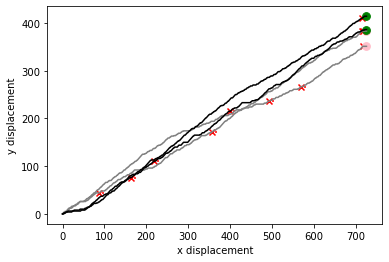

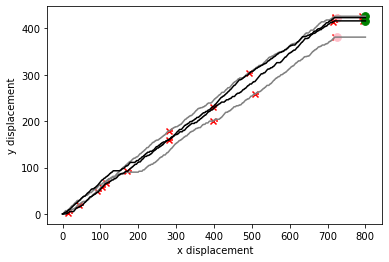

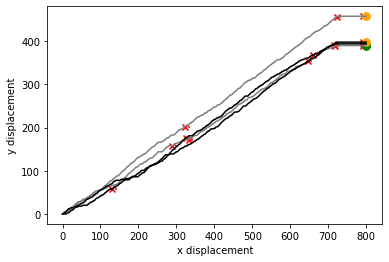

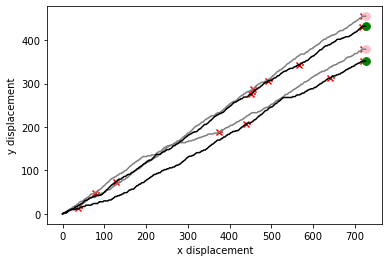

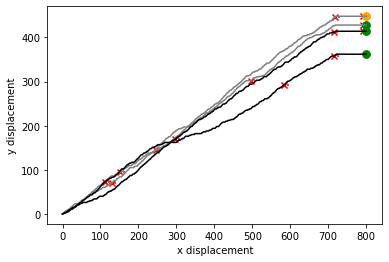

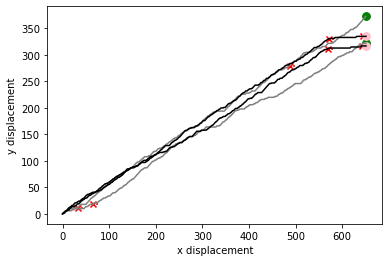

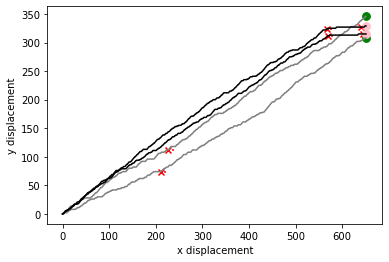

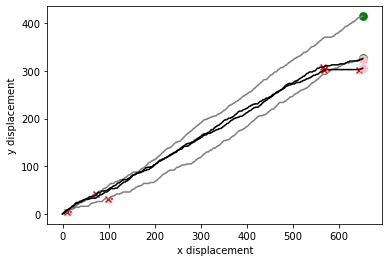

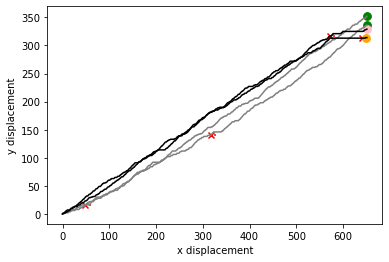

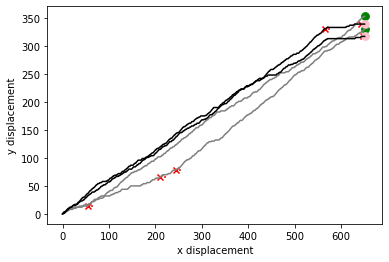

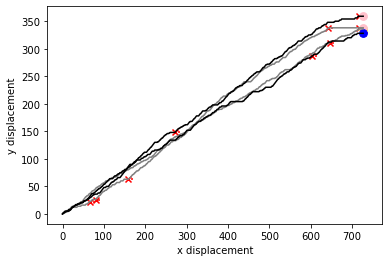

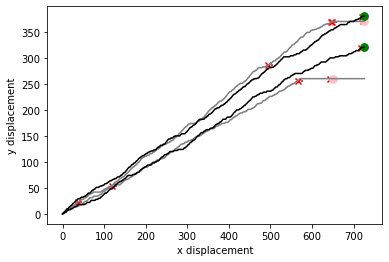

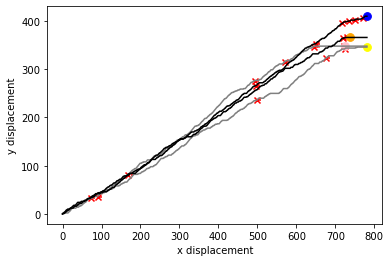

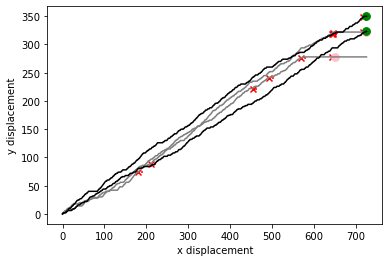

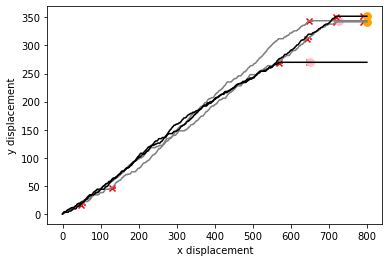

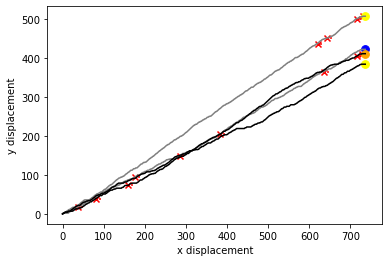

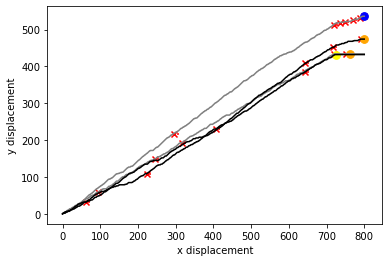

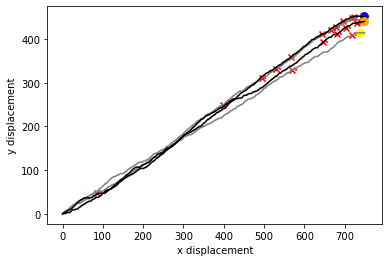

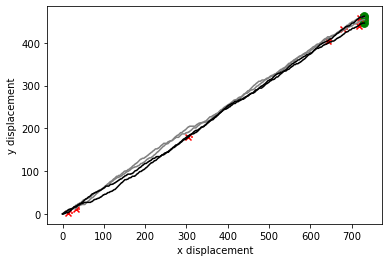

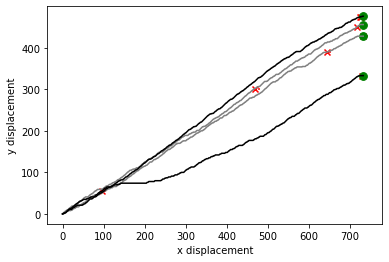

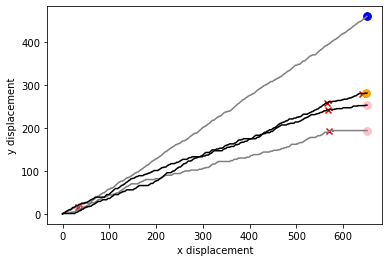

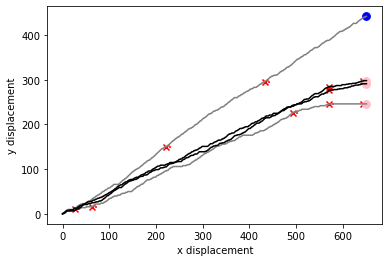

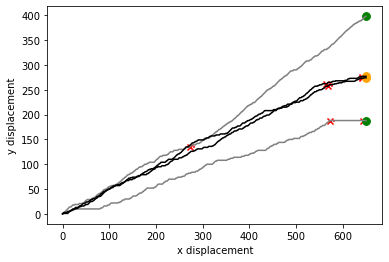

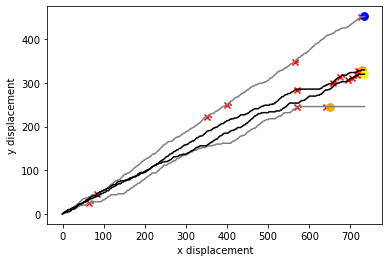

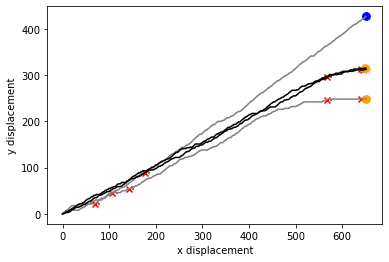

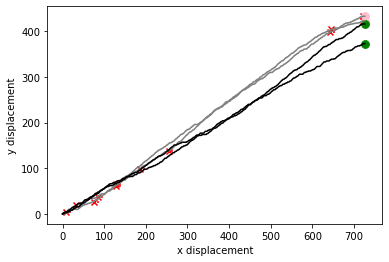

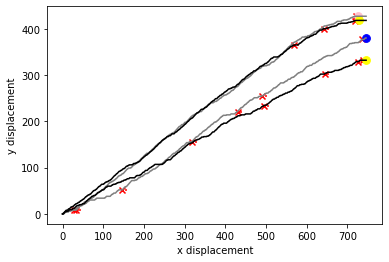

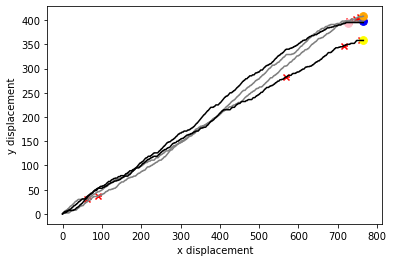

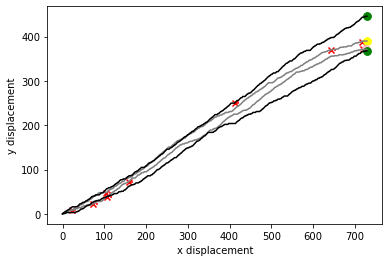

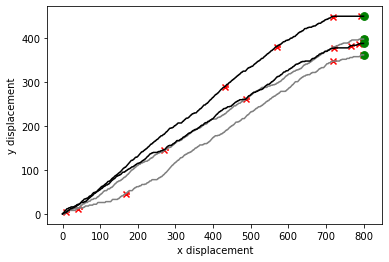

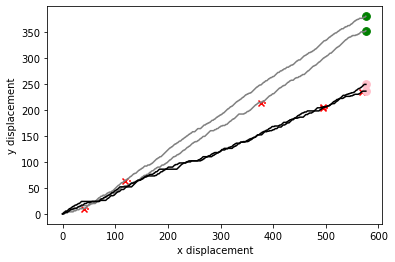

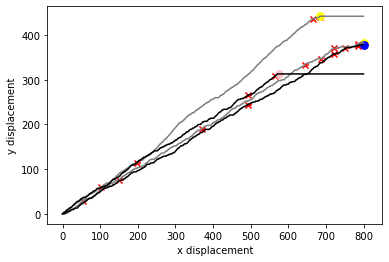

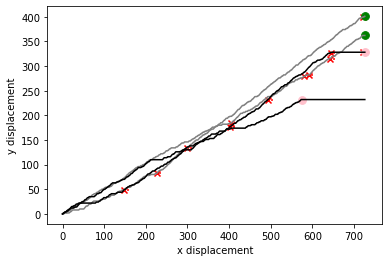

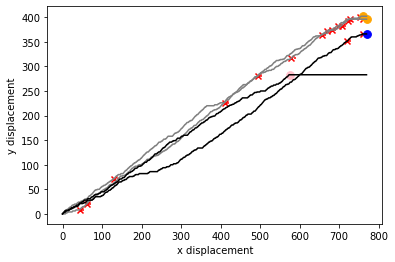

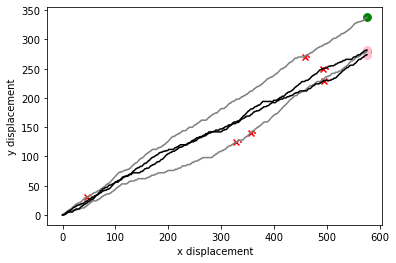

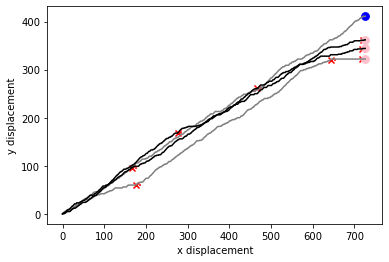

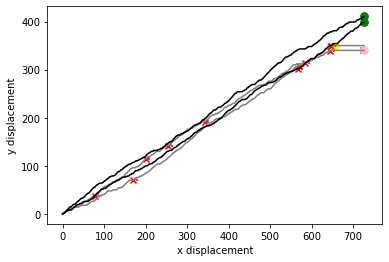

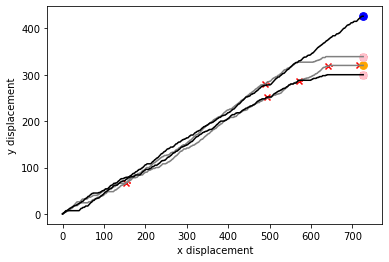

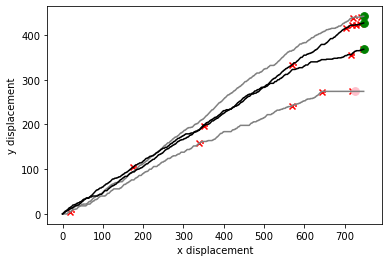

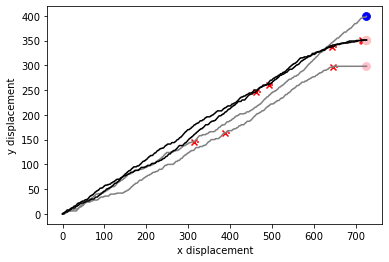

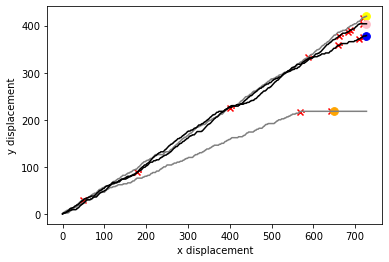

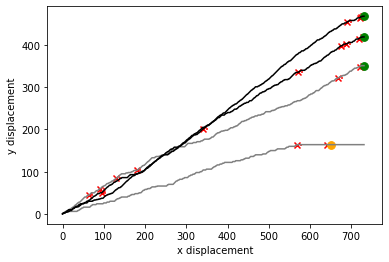

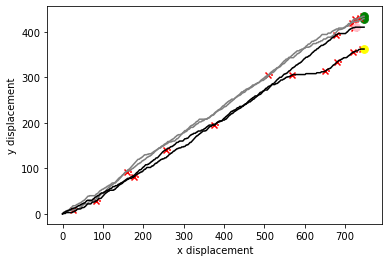

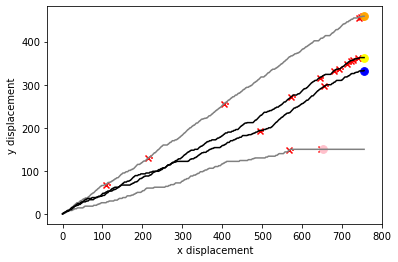

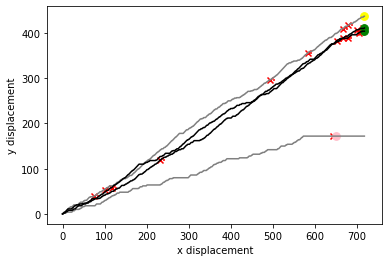

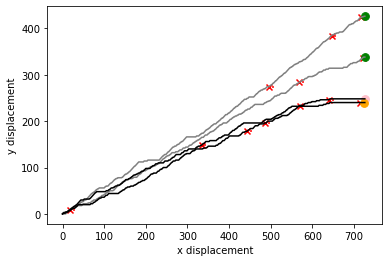

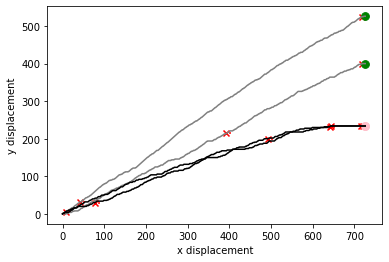

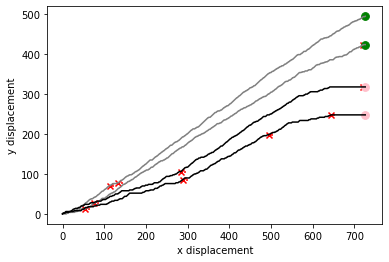

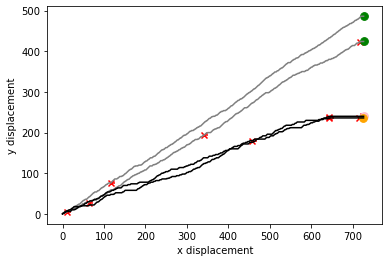

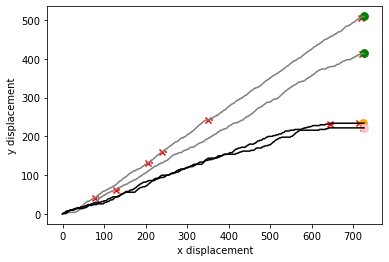

In [638]:

df = pd.DataFrame()
players = ['p10', 'p11', 'p12', 'p13']
sum_arr = [ [0] * 11 for i1 in range(11) ]
os.mkdir(path+'figs')

for game_no in range(1,51):
    print(game_no)
    agents_df, game_df, board_df = get_data(path, game_no)

    dead_guys = death_func(game_df)
    dead_df = pd.DataFrame.from_dict(dead_guys, orient='index')
    dead_df['game_no'] = game_no

    dead_df, movement = get_avg_valid(players, game_df, agents_df, dead_df)
    dead_df, bombs_placed = get_net_bombs(players, agents_df, dead_df)
    dead_df, power_up = get_power_sums(dead_df, players, agents_df, bombs_placed, board_df)
    dead_df, new_arr = exploration(dead_df, players, movement)
    sum_arr = add_arrays(sum_arr, new_arr)

    destroy_df = bomb_destruction(players, bombs_placed, agents_df, board_df)
    dead_df = sum_up_destroy(dead_df, destroy_df)
    dead_df, destroy_df = who_killed_who(dead_df, destroy_df)


    dead_df = make_graph(players, movement, bombs_placed, dead_df, game_no, path)

    df = pd.concat([df, dead_df])

    if dead_df.shape[0]<4:
        print(game_no, dead_df.shape[0])


# Fixes meant specifically for TEAM mode

## Incase our agents were tying against eachother

In [639]:
for i in range(1,51):
    dx = df.loc[df.game_no==i]
    if dx.loc[dx.player==11, 'death_how'].values[0] == 'tie':
        if dx.loc[dx.player==13, 'death_how'].values[0] == 'tie':
            if dx.loc[dx.player==12, 'death_how'].values[0] != 'tie':
                if dx.loc[dx.player==10, 'death_how'].values[0] != 'tie':
                    df.loc[(df.game_no==i) & (df.player==11), 'death_how'] = 'winner'
                    df.loc[(df.game_no==i) & (df.player==13), 'death_how'] = 'winner'


Utility stuff

In [643]:
color = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange']
#color = {'p10' : 'tab:blue', 'p11' : 'tab:blue', 'p12' : 'tab:blue', 'p13' : 'tab:orange'}

In [640]:
df.player = df.player.astype('category')

# Analysis

## Main dataframe for all games
4 rows per game. One for each player.
<br>Therefore 50 games shall give you 200 rows

In [641]:
df

,dead_tick,player,how_many_dead,death_how,game_no,valid_moves,bombs,power_ups,tiles_explored,players_killed,wood_bombed,powers_bombed,bomb_chained,killed_by,total_steps
0,726,10,2,collapsing_wall,1,72.038567,3,0,46,0,4,0,0,0,383
1,726,12,2,collapsing_wall,1,70.523416,3,0,41,0,0,0,0,0,351
2,726,11,2,winner,1,77.272727,2,1,38,0,2,0,0,0,414
3,726,13,2,winner,1,75.068871,4,0,54,0,5,0,0,0,386
0,726,10,2,collapsing_wall,2,74.125000,3,0,47,0,4,0,1,0,381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,726,12,2,tie,49,79.476584,3,1,23,0,2,0,0,0,424
0,724,11,1,suicide,50,54.820937,2,0,14,0,1,0,0,11,234
1,726,13,1,collapsing_wall,50,50.688705,1,0,14,0,0,0,0,0,222
2,726,10,2,tie,50,88.567493,5,1,35,0,4,0,0,0,510


### Heatmap of tiles explored by agent

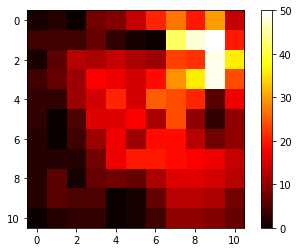

In [642]:
plot_heatmap(sum_arr, path)

# Bar Graphs comparing average stats for the 4 player over 50 games

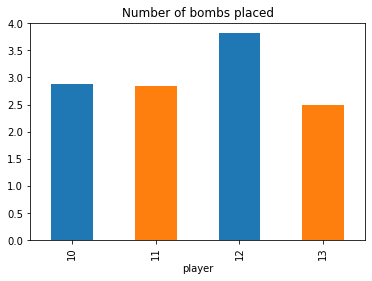

In [644]:
fig = df.groupby('player')['bombs'].mean().plot.bar(color = color, title = 'Number of bombs placed').get_figure()
fig.savefig(path+'figs/bombs_placed.pdf')

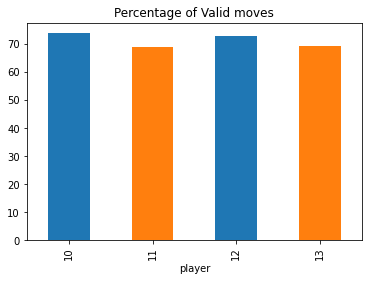

In [645]:
fig = df.groupby('player')['valid_moves'].mean().plot.bar(color = color, title = 'Percentage of Valid moves').get_figure()
fig.savefig(path+'figs/valid_moves.pdf')

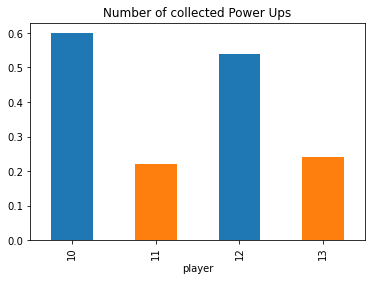

In [646]:
fig = df.groupby('player')['power_ups'].mean().plot.bar(color = color, title = 'Number of collected Power Ups').get_figure()
fig.savefig(path+'figs/power_ups.pdf')

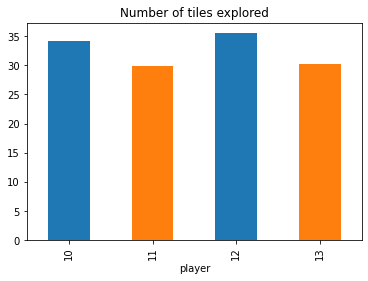

In [647]:
fig = df.groupby('player')['tiles_explored'].mean().plot.bar(color = color, title = 'Number of tiles explored').get_figure()
fig.savefig(path+'figs/tiles_explored.pdf')

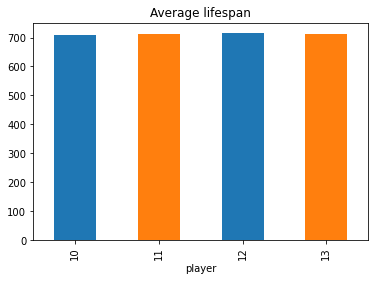

In [648]:
fig = df.groupby('player')['dead_tick'].mean().plot.bar(color = color, title = 'Average lifespan').get_figure()
fig.savefig(path+'figs/lifespan.pdf')

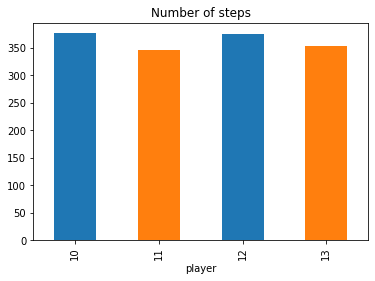

In [649]:
fig = df.groupby('player')['total_steps'].mean().plot.bar(color = color, title = 'Number of steps').get_figure()
fig.savefig(path+'figs/steps.pdf')

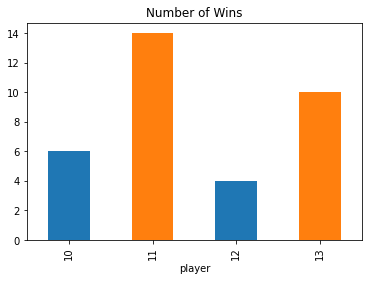

In [650]:
fig = df.loc[df.death_how=='winner'].groupby('player')['game_no'].count().plot.bar(color = color, title = 'Number of Wins').get_figure()
fig.savefig(path+'figs/wins.pdf')

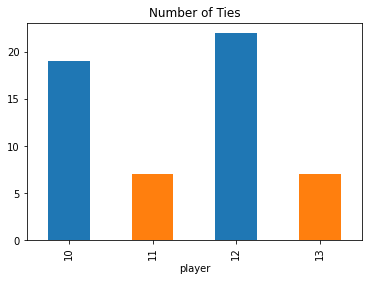

In [651]:
fig = df.loc[df.death_how=='tie'].groupby('player')['game_no'].count().plot.bar(color = color, title = 'Number of Ties').get_figure()
fig.savefig(path+'figs/ties.pdf')


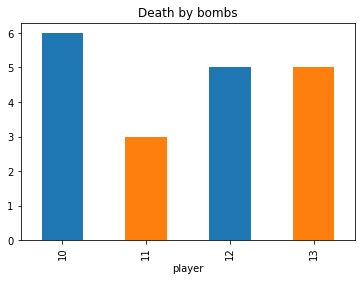

In [652]:
fig = df.loc[df.death_how=='bombed'].groupby('player')['game_no'].count().plot.bar(color = color, title = 'Death by bombs').get_figure()
fig.savefig(path+'figs/death_by_bombs.pdf')

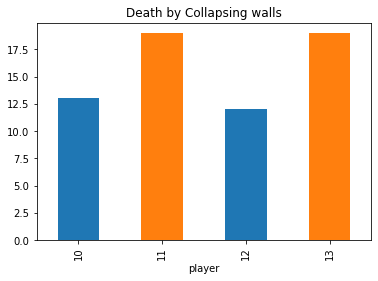

In [653]:
fig = df.loc[df.death_how=='collapsing_wall'].groupby('player')['game_no'].count().plot.bar(color = color, title = 'Death by Collapsing walls').get_figure()
fig.savefig(path+'figs/death_by_collapsing_walls.pdf')

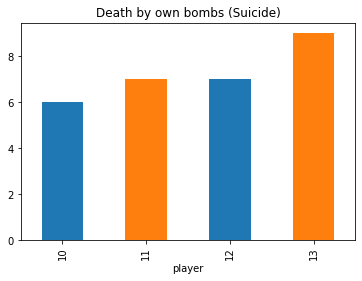

In [654]:
fig = df.loc[df.death_how=='suicide'].groupby('player')['game_no'].count().plot.bar(color = color, title = 'Death by own bombs (Suicide)').get_figure()
fig.savefig(path+'figs/Suicide.pdf')

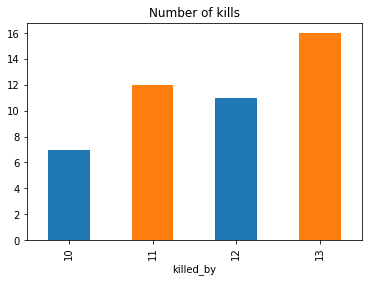

In [655]:
fig = df.groupby('killed_by')['game_no'].count()[1:].plot.bar(color=color, title = 'Number of kills').get_figure()
fig.savefig(path+'figs/kills.pdf')

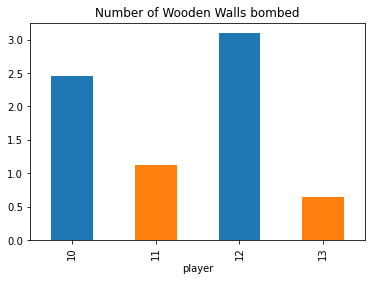

In [656]:
fig = df.groupby('player')['wood_bombed'].mean().plot.bar(color=color, title = 'Number of Wooden Walls bombed').get_figure()
fig.savefig(path+'figs/wood_walls.pdf')

In [657]:
df

,dead_tick,player,how_many_dead,death_how,game_no,valid_moves,bombs,power_ups,tiles_explored,players_killed,wood_bombed,powers_bombed,bomb_chained,killed_by,total_steps
0,726,10,2,collapsing_wall,1,72.038567,3,0,46,0,4,0,0,0,383
1,726,12,2,collapsing_wall,1,70.523416,3,0,41,0,0,0,0,0,351
2,726,11,2,winner,1,77.272727,2,1,38,0,2,0,0,0,414
3,726,13,2,winner,1,75.068871,4,0,54,0,5,0,0,0,386
0,726,10,2,collapsing_wall,2,74.125000,3,0,47,0,4,0,1,0,381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,726,12,2,tie,49,79.476584,3,1,23,0,2,0,0,0,424
0,724,11,1,suicide,50,54.820937,2,0,14,0,1,0,0,11,234
1,726,13,1,collapsing_wall,50,50.688705,1,0,14,0,0,0,0,0,222
2,726,10,2,tie,50,88.567493,5,1,35,0,4,0,0,0,510


## Saving Dataframe

In [658]:
df.to_csv(path+'analysis/dataframe.csv')